In [21]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy
from collections import defaultdict, Counter
import datetime

from upsetplot import from_contents,plot
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
print(os.getcwd())
sys.path.insert(0, str(os.path.dirname(os.path.realpath(os.getcwd()))))
print(sys.path)

/mnt/f/dev/git/miRExplore/python/nbs
['/mnt/f/dev/git/miRExplore/python', '/mnt/f/dev/git/miRExplore/python/nbs', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/local/lib/python3.8/dist-packages/mpld3-0.3.1.dev1-py3.8.egg', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/home/mjoppich/.ipython']


In [22]:
%autoreload 2
from textdb.PubmedDateDB import PubmedDateDB
%autoreload 2
from synonymes.mirnaID import miRNA, miRNAPART
%autoreload 2
from textdb.MiGenRelDB import MiGenRelDB,MiRGeneRel
%autoreload 2
from synonymes.GeneOntology import GeneOntology
%autoreload 2
from textdb.PMID2XDB import PMID2XDB
from textdb.PMID2PMCDB import PMID2PMCDB
from textdb.MirTarBaseDB import MirTarBaseDB
from analysis.miRecordDB import miRecordDB
from textdb.DIANATarbaseDB import DIANATarbaseDB


In [24]:
pmidBase ="/mnt/f/dev/data/pmid_jun2020/aggregated_pmid/"
pmcBase ="/mnt/f/dev/data/pmid_jun2020/aggregated_pmc/"
obodir = "/mnt/f/dev/data/pmid_jun2020/obodir/"

fileDir = os.path.dirname(os.path.realpath(os.getcwd()))

In [5]:
from utils.tmutils import normalize_gene_names
normGeneSymbols = normalize_gene_names(path="/mnt/d/owncloud/data/miRExplore/obodir/" + "/hgnc_no_withdrawn.syn")

In [68]:
pmid2pmcDB = PMID2PMCDB.loadFromFile(pmcBase + '/pmc2pmid', PMC2PMID=True)
excludePMIDs = pmid2pmcDB.getAllPMIDs()
excludePMCs = pmid2pmcDB.getAllPMCs()

In [69]:
print("Loading hsa")
mirelPMIDhsa = MiGenRelDB.loadFromFile(pmidBase + "/mirna_gene.hsa.pmid", ltype="mirna", rtype="gene", normGeneSymbols=normGeneSymbols, switchLR=True, stopAfter=-1)
print("Loading mmu")
mirelPMIDmmu = MiGenRelDB.loadFromFile(pmidBase + "/mirna_gene.mmu.pmid", ltype="mirna", rtype="gene", normGeneSymbols=normGeneSymbols, switchLR=True, stopAfter=-1)

print("Loading hsa")
mirelPMChsa = MiGenRelDB.loadFromFile(pmcBase + "/mirna_gene.hsa.pmid", ltype="mirna", rtype="gene", normGeneSymbols=normGeneSymbols, switchLR=True, stopAfter=-1)
print("Loading mmu")
mirelPMCmmu = MiGenRelDB.loadFromFile(pmcBase + "/mirna_gene.mmu.pmid", ltype="mirna", rtype="gene", normGeneSymbols=normGeneSymbols, switchLR=True, stopAfter=-1)



relDBs = [mirelPMIDhsa, mirelPMIDmmu, mirelPMChsa, mirelPMCmmu]

Loading hsa
Gene Symbols Normalized 77476
Loaded file /mnt/f/dev/data/pmid_jun2020/aggregated_pmid//mirna_gene.hsa.pmid
Accepted Doc IDs 40682
Rejected Doc IDs 0
Seen genes 7906
Seen miRNAs 2116
Seen Harm. miRNAs 1615
Loading mmu
Gene Symbols Normalized 12375
Loaded file /mnt/f/dev/data/pmid_jun2020/aggregated_pmid//mirna_gene.mmu.pmid
Accepted Doc IDs 36823
Rejected Doc IDs 0
Seen genes 6431
Seen miRNAs 2048
Seen Harm. miRNAs 1578
Loading hsa
Gene Symbols Normalized 104649
Loaded file /mnt/f/dev/data/pmid_jun2020/aggregated_pmc//mirna_gene.hsa.pmid
Accepted Doc IDs 10749
Rejected Doc IDs 0
Seen genes 6911
Seen miRNAs 1868
Seen Harm. miRNAs 1312
Loading mmu
Gene Symbols Normalized 23456
Loaded file /mnt/f/dev/data/pmid_jun2020/aggregated_pmc//mirna_gene.mmu.pmid
Accepted Doc IDs 10647
Rejected Doc IDs 0
Seen genes 6056
Seen miRNAs 1872
Seen Harm. miRNAs 1323


In [50]:
sourceCompLevel = [miRNAPART.MATURE, miRNAPART.ID] #, miRNAPART.PRECURSOR

In [ ]:
recordsDB = miRecordDB.loadFromFile(filelocation=fileDir + "/dbs/mirecords_v4.xlsx", normGeneSymbols=normGeneSymbols)
mirtarbaseDB = MirTarBaseDB.loadFromFile(filepath=fileDir + "/dbs/miRTarBase.csv", normGeneSymbols=normGeneSymbols)
dianaDB, celllInfos = DIANATarbaseDB.loadFromFile(fileDir + "/dbs/hsa_mmu.diana.csv", normGeneSymbols=normGeneSymbols)


In [51]:
tmInteractions = set()

for rdb in relDBs:

    for gene in rdb.ltype2rel:

        for rel in rdb.ltype2rel[gene]:

            mirObj = miRNA(rel.rid)

            #fullMirna = mirObj.getStringFromParts([miRNAPART.MATURE, miRNAPART.ID, miRNAPART.PRECURSOR, miRNAPART.MATURE_SEQS, miRNAPART.ARM])
            baseMirna = mirObj.getStringFromParts(sourceCompLevel)
            intTuple = (rel.lid, baseMirna)

            tmInteractions.add(intTuple)

In [52]:
mirecordsInteractions = set()

for gene in recordsDB.ltype2rel:

    for rel in recordsDB.ltype2rel[gene]:

        mirObj = miRNA(rel.rid)

        #fullMirna = mirObj.getStringFromParts([miRNAPART.MATURE, miRNAPART.ID, miRNAPART.PRECURSOR, miRNAPART.MATURE_SEQS, miRNAPART.ARM])
        baseMirna = mirObj.getStringFromParts(sourceCompLevel)
        intTuple = (rel.lid, baseMirna)

        mirecordsInteractions.add(intTuple)

In [53]:

mirtarbaseInteractions = set()

for gene in mirtarbaseDB.ltype2rel:

    for rel in mirtarbaseDB.ltype2rel[gene]:

        mirObj = miRNA(rel.rid)

        #fullMirna = mirObj.getStringFromParts([miRNAPART.MATURE, miRNAPART.ID, miRNAPART.PRECURSOR, miRNAPART.MATURE_SEQS, miRNAPART.ARM])
        baseMirna = mirObj.getStringFromParts(sourceCompLevel)
        intTuple = (rel.lid, baseMirna)

        mirtarbaseInteractions.add(intTuple)

In [54]:

dianaInteractions = set()

for gene in dianaDB.ltype2rel:

    for rel in dianaDB.ltype2rel[gene]:

        mirObj = miRNA(rel.rid)

        #fullMirna = mirObj.getStringFromParts([miRNAPART.MATURE, miRNAPART.ID, miRNAPART.PRECURSOR, miRNAPART.MATURE_SEQS, miRNAPART.ARM])
        baseMirna = mirObj.getStringFromParts( sourceCompLevel )
        intTuple = (rel.lid, baseMirna)

        dianaInteractions.add(intTuple)

In [55]:
print(list(tmInteractions)[:4])
print(list(mirecordsInteractions)[:4])
print(list(mirtarbaseInteractions)[:4])
print(list(dianaInteractions)[:4])

[('FOXO1', 'miR-126'), ('CP', 'miR-17'), ('CD4', 'miR-124'), ('FAM138B', 'miR-15')]
[('FLT1', 'miR-200'), ('MYLIP', 'miR-19'), ('NTRK3', 'miR-509'), ('TRMT13', 'miR-15')]
[('C6ORF62', 'miR-92'), ('FOXE1', 'miR-3653'), ('KLHL4', 'miR-1236'), ('CLCC1', 'miR-7106')]
[('C6ORF62', 'miR-92'), ('CCNG2', 'let-7'), ('COG3', 'miR-322'), ('PANK3', 'miR-132')]


In [56]:
source2interactions = {}
source2interactions["tm"] = tmInteractions
source2interactions["miRecords"] = mirecordsInteractions
source2interactions["miRTarBase"] = mirtarbaseInteractions
source2interactions["DIANA-TarBase"] = dianaInteractions

In [59]:
printed = 0
for x in tmInteractions:
    
    if not x in source2interactions["miRecords"]:
        if not x in source2interactions["miRTarBase"]:
            if not x in source2interactions["DIANA-TarBase"]:
                
                print(x)
                printed += 1
                
                if printed > 5:
                    break
    

('FOXO1', 'miR-126')
('CD4', 'miR-124')
('FAM138B', 'miR-15')
('CD34', 'miR-150')
('MC4R', 'miR-194')
('SLC52A2', 'miR-200')


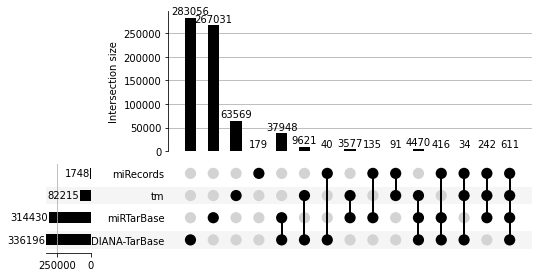

In [57]:
upIn = from_contents(source2interactions)
plot(upIn, subset_size="auto", show_counts =True)
plt.savefig("database_overlap_withpmc.png")

In [10]:
miRNAGenePMIDs = set()
for rdb in relDBs:
    for rpmid in rdb.get_evidence_docids():
        miRNAGenePMIDs.add(rpmid)

In [11]:
len(miRNAGenePMIDs)

44015

In [12]:
diseaseObo = GeneOntology(obodir + "/doid.obo")

#{'group': 'disease', 'termid': 'DOID:1936', 'name': 'atherosclerosis'}
#{'group': 'disease', 'termid': 'DOID:2349', 'name': 'arteriosclerosis'}
#{'group': 'disease', 'termid': 'DOID:1287', 'name': 'cardiovascular system disease'},
elemTerm = diseaseObo['DOID:1936']
elemTerms = [x.term.id for x in elemTerm.getAllChildren()] + [elemTerm.id]

cvTerm = diseaseObo['DOID:1287']
cvTerms = [x.term.id for x in cvTerm.getAllChildren()] + [cvTerm.id] + elemTerms

pmid2disease = PMID2XDB.loadFromFile(pmidBase + "/disease.pmid", diseaseObo, miRNAGenePMIDs)

0
10000
no parent 2382


In [13]:
# number of genes with interaction
allGenes = set()

for rdb in relDBs:
    allGenes = allGenes.union(set(rdb.all_ltypes))

print("Number of genes with interaction", len(allGenes))

Number of genes with interaction 8779


In [14]:
# number of miRNAs with interaction
## restrict to miR-x
allMirnas = set()
for rdb in relDBs:
    for mirna in rdb.all_rtypes:

        try:
            mirObj = miRNA(mirna)
            allMirnas.add(mirObj.getStringFromParts([miRNAPART.MATURE, miRNAPART.ID, miRNAPART.PRECURSOR]))

        except:

            print(mirna)
            exit(-1)

print("Number of mirnas with interaction", len(allMirnas))
print("DO NOT USE THIS NUMBER!!!!")

Number of mirnas with interaction 1307
DO NOT USE THIS NUMBER!!!!


In [15]:
for rdb in relDBs:
    for midx, mirna in enumerate(rdb.all_rtypes):
        print(mirna, type(mirna))
        
        if midx > 7:
            break
    

miR-339 <class 'str'>
hsa-miR-3171 <class 'str'>
hsa-miR-4306 <class 'str'>
hsa-miR-92a <class 'str'>
miR-150-mediated <class 'str'>
hsa-miR-382 <class 'str'>
miR-1827 <class 'str'>
mmu-miR-223 <class 'str'>
miR-196 <class 'str'>
miR-339 <class 'str'>
hsa-miR-3171 <class 'str'>
hsa-miR-4306 <class 'str'>
hsa-miR-92a <class 'str'>
miR-150-mediated <class 'str'>
hsa-miR-382 <class 'str'>
miR-1827 <class 'str'>
mmu-miR-223 <class 'str'>
miR-196 <class 'str'>
miR-1947 <class 'str'>
miR-339 <class 'str'>
hsa-miR-92a <class 'str'>
miR-150-mediated <class 'str'>
hsa-miR-382 <class 'str'>
mmu-miR-16 <class 'str'>
miR-1827 <class 'str'>
miR-1194 <class 'str'>
mmu-miR-223 <class 'str'>
miR-1947 <class 'str'>
miR-339 <class 'str'>
miR-7150 <class 'str'>
hsa-miR-92a <class 'str'>
miR-150-mediated <class 'str'>
hsa-miR-382 <class 'str'>
mmu-miR-16 <class 'str'>
miR-1827 <class 'str'>
miR-1194 <class 'str'>


In [16]:
seenFullMirs = set()
seenShortMirs = set()

for rdb in relDBs:

    for gidx, gene in enumerate(rdb.ltype2rel):

        for rel in rdb.ltype2rel[gene]:
            
            
            mirstr = rel.orig_names[1]
            
            assert(mirstr == rel.rid)
            
            omir = miRNA(mirstr)
            fullMirna = omir.getStringFromParts([miRNAPART.MATURE, miRNAPART.ID, miRNAPART.PRECURSOR, miRNAPART.MATURE_SEQS, miRNAPART.ARM])
            shortMirna = omir.getStringFromParts([miRNAPART.MATURE, miRNAPART.ID, miRNAPART.PRECURSOR])
            
            #print(mirstr, fullMirna)
            
            seenFullMirs.add(fullMirna)
            seenShortMirs.add(shortMirna)

            
print("Short miRNAs", len(seenShortMirs))
print("Full miRNAs", len(seenFullMirs))

Short miRNAs 1307
Full miRNAs 1753


In [70]:
pmid2interactions = defaultdict(set)

for rdb in [mirelPMIDhsa, mirelPMIDmmu]:

    for gene in rdb.ltype2rel:

        for rel in rdb.ltype2rel[gene]:

            mirObj = miRNA(rel.rid)

            fullMirna = mirObj.getStringFromParts([miRNAPART.MATURE, miRNAPART.ID, miRNAPART.PRECURSOR, miRNAPART.MATURE_SEQS, miRNAPART.ARM])
            baseMirna = mirObj.getStringFromParts(sourceCompLevel)
            
            pmid2interactions[rel.docid].add( (rel.lid, baseMirna) )
            pmid2interactions[rel.docid].add( (rel.lid, fullMirna) )

In [61]:


def calculateStatistics(relDBs, filter=None):

    interactionsWithDisease = set()

    interactionsWithAthero = set()
    atheroPubmeds = set()
    cvPubmeds = set()
    allPubmeds = set()

    interactionsWithCV = set()
    totalMirnas = set()
    totalMirnasFull = set()
    totalGenes = set()

    totalInteractions = set()
    
    interactionByRegDir = defaultdict(set)

    for rdb in relDBs:

        for gene in rdb.ltype2rel:

            for rel in rdb.ltype2rel[gene]:

                #print(rel)
                #assert(1==0)


                if filter != None:
                    
                    if filter(rel):
                        continue

                
                        
                mirObj = miRNA(rel.rid)
                
                fullMirna = mirObj.getStringFromParts([miRNAPART.MATURE, miRNAPART.ID, miRNAPART.PRECURSOR, miRNAPART.MATURE_SEQS, miRNAPART.ARM])
                totalMirnasFull.add(fullMirna)

                baseMirna = mirObj.getStringFromParts([miRNAPART.MATURE, miRNAPART.ID, miRNAPART.PRECURSOR])
                intTuple = (rel.lid, baseMirna)

                totalInteractions.add(intTuple)
                
                interactionByRegDir[(rel.assocInt, rel.assocCat)].add(intTuple)
                
                totalMirnas.add(intTuple[1])
                totalGenes.add(intTuple[0])

                docID = rel.docid
                retVal = pmid2disease.getDOC(docID)

                allPubmeds.add(docID)

                if retVal != None:


                    interactionsWithDisease.add(intTuple)

                    for docDisease in retVal:

                        if docDisease['termid'] in elemTerms:
                            interactionsWithAthero.add(intTuple)
                            atheroPubmeds.add(docID)

                        if docDisease['termid'] in cvTerms:
                            interactionsWithCV.add(intTuple)
                            cvPubmeds.add(docID)
                            
    print("Different miRNAs", len(totalMirnas))
    print("Different miRNAs (full)", len(totalMirnasFull))
    print("Different genes", len(totalGenes))

    print("total Interactions", len(totalInteractions))
    print("total mirnas in interactions", len(set([x[1] for x in totalInteractions])))


    print("total interactions with disease", len(interactionsWithDisease))
    print("total mirnas in interactions with disease", len(set([x[1] for x in interactionsWithDisease])))

    atheroMirnas = set([x[1] for x in interactionsWithAthero])
    atheroGenes = set([x[0] for x in interactionsWithAthero])

    print("total interactions with athero", len(interactionsWithAthero))
    print("total mirnas in interactions with athero", len(atheroMirnas))
    print("total genes in interactions with athero", len(atheroGenes))
    print("total pubmeds for interactions with athero", len(atheroPubmeds))
    print("total pubmeds for interactions with cv", len(cvPubmeds))
    print("total pubmeds for interactions", len(allPubmeds))

    print("total interactions with cv", len(interactionsWithCV))
    print("total mirnas in interactions with cv", len(set([x[1] for x in interactionsWithCV])))
    
    print()
    
    for x in sorted(interactionByRegDir):
        print(x, len(interactionByRegDir[x]))

In [62]:
calculateStatistics(relDBs = [mirelPMIDhsa, mirelPMIDmmu])

Different miRNAs 1307
Different miRNAs (full) 1753
Different genes 8779
total Interactions 94300
total mirnas in interactions 1307
total interactions with disease 43490
total mirnas in interactions with disease 1007
total interactions with athero 1017
total mirnas in interactions with athero 152
total genes in interactions with athero 456
total pubmeds for interactions with athero 381
total pubmeds for interactions with cv 2523
total pubmeds for interactions 44015
total interactions with cv 5798
total mirnas in interactions with cv 425

('GENE_MIR', 'CHNAGE') 2
('GENE_MIR', 'DOWN') 12737
('GENE_MIR', 'NEU') 26147
('GENE_MIR', 'UP') 13179
('MIR_GENE', 'CHNAGE') 5
('MIR_GENE', 'DOWN') 36615
('MIR_GENE', 'NAN') 2
('MIR_GENE', 'NEU') 60527
('MIR_GENE', 'UP') 21500


In [64]:
calculateStatistics(relDBs = [mirelPMChsa, mirelPMCmmu])

Different miRNAs 979
Different miRNAs (full) 1257
Different genes 6256
total Interactions 54499
total mirnas in interactions 979
total interactions with disease 0
total mirnas in interactions with disease 0
total interactions with athero 0
total mirnas in interactions with athero 0
total genes in interactions with athero 0
total pubmeds for interactions with athero 0
total pubmeds for interactions with cv 0
total pubmeds for interactions 10152
total interactions with cv 0
total mirnas in interactions with cv 0

('GENE_MIR', 'CHNAGE') 2
('GENE_MIR', 'DOWN') 7278
('GENE_MIR', 'NEU') 16792
('GENE_MIR', 'UP') 7824
('MIR_GENE', 'DOWN') 18501
('MIR_GENE', 'NAN') 2
('MIR_GENE', 'NEU') 34514
('MIR_GENE', 'UP') 12512


In [73]:
def filterFunc(rel):
    relDocID = rel.docid
    
    relDocPMID = pmid2pmcDB.pmc2pmid.get(relDocID, None)
    
    if relDocPMID == None:
        # no abstract existing for PMC
        return False
    
    mirObj = miRNA(rel.rid)

    fullMirna = mirObj.getStringFromParts([miRNAPART.MATURE, miRNAPART.ID, miRNAPART.PRECURSOR, miRNAPART.MATURE_SEQS, miRNAPART.ARM])
    baseMirna = mirObj.getStringFromParts(sourceCompLevel)
    
    gene = rel.lid
    
    for pmid in relDocPMID:
        pmidInteractions = pmid2interactions[pmid]

        if (gene, fullMirna) in pmidInteractions:
            return True

        if (gene, baseMirna) in pmidInteractions:
            return True
    
    return False

# only additional PMC miRNA-gene hits
calculateStatistics(relDBs = [mirelPMChsa, mirelPMCmmu], filter=filterFunc)

Different miRNAs 974
Different miRNAs (full) 1223
Different genes 6169
total Interactions 52945
total mirnas in interactions 974
total interactions with disease 0
total mirnas in interactions with disease 0
total interactions with athero 0
total mirnas in interactions with athero 0
total genes in interactions with athero 0
total pubmeds for interactions with athero 0
total pubmeds for interactions with cv 0
total pubmeds for interactions 10118
total interactions with cv 0
total mirnas in interactions with cv 0

('GENE_MIR', 'CHNAGE') 2
('GENE_MIR', 'DOWN') 6158
('GENE_MIR', 'NEU') 15147
('GENE_MIR', 'UP') 6792
('MIR_GENE', 'DOWN') 16938
('MIR_GENE', 'NAN') 2
('MIR_GENE', 'NEU') 33016
('MIR_GENE', 'UP') 11229


In [63]:
def filterFunc(rel):
    relOrgs = rel.orgs
    if relOrgs == None:
        relOrgs = set()

    if not ('mmu' in relOrgs or 'hsa' in relOrgs):
        return True
    
    return False

In [65]:
calculateStatistics(relDBs = [mirelPMIDhsa, mirelPMIDmmu, mirelPMChsa, mirelPMCmmu], filter=filterFunc)    

Different miRNAs 1162
Different miRNAs (full) 1530
Different genes 7602
total Interactions 72980
total mirnas in interactions 1162
total interactions with disease 21942
total mirnas in interactions with disease 771
total interactions with athero 617
total mirnas in interactions with athero 119
total genes in interactions with athero 305
total pubmeds for interactions with athero 222
total pubmeds for interactions with cv 1119
total pubmeds for interactions 24859
total interactions with cv 2772
total mirnas in interactions with cv 302

('GENE_MIR', 'CHNAGE') 2
('GENE_MIR', 'DOWN') 9823
('GENE_MIR', 'NEU') 20513
('GENE_MIR', 'UP') 10254
('MIR_GENE', 'DOWN') 27527
('MIR_GENE', 'NAN') 2
('MIR_GENE', 'NEU') 45994
('MIR_GENE', 'UP') 16813


In [66]:
calculateStatistics(relDBs = [mirelPMChsa, mirelPMCmmu], filter=filterFunc)

Different miRNAs 976
Different miRNAs (full) 1252
Different genes 6210
total Interactions 53942
total mirnas in interactions 976
total interactions with disease 0
total mirnas in interactions with disease 0
total interactions with athero 0
total mirnas in interactions with athero 0
total genes in interactions with athero 0
total pubmeds for interactions with athero 0
total pubmeds for interactions with cv 0
total pubmeds for interactions 9893
total interactions with cv 0
total mirnas in interactions with cv 0

('GENE_MIR', 'CHNAGE') 2
('GENE_MIR', 'DOWN') 7233
('GENE_MIR', 'NEU') 16592
('GENE_MIR', 'UP') 7756
('MIR_GENE', 'DOWN') 18418
('MIR_GENE', 'NAN') 2
('MIR_GENE', 'NEU') 34079
('MIR_GENE', 'UP') 12414


In [ ]:
def filterFunc(rel):
    relOrgs = rel.orgs
    if relOrgs == None:
        relOrgs = set()

    if not ('mmu' in relOrgs or 'hsa' in relOrgs):
        return True
    
    return False